In [2]:
# %% Import libraries
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import seaborn as sns
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, \
                                    cross_val_score, \
                                    cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, \
                                    accuracy_score, \
                                    precision_score, \
                                    recall_score, \
                                    classification_report
from tpot import TPOTClassifier

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
# function definitions

def pca(df):
    
    # standardize the features matrix
    features = StandardScaler().fit_transform(df)
    
    # Create a PCA that retains 99% of the variance
    pca = PCA(n_components = 0.95)
    features_pca = pca.fit_transform(features)
    
    return features, features_pca


def plot_cm(cm):
    # plot confusion matrix
    fig, ax = plt.subplots(figsize = (10,8))
    
    sns.heatmap(conf_matrix_rf/np.sum(conf_matrix_rf), annot=True, 
                fmt='.2%', cmap='Blues', annot_kws={'size':15})
    
    ax.set_title('Random Forest Confusion Matrix', fontsize = 18, loc='left')
    
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 12)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 12)
    
    plt.show()

In [5]:
# %% read df_final
# Read the Kepler Objects of Interest (KOI) df_final and look at one observation
df_koi = pd.read_csv('../data/cumulative_2021.03.16_17.10.21.csv')
print(df_koi.shape)
print(df_koi[1:2].T)

(9564, 141)
                                                                    1
rowid                                                               2
kepid                                                        10797460
kepoi_name                                                  K00752.02
kepler_name                                              Kepler-227 c
koi_disposition                                             CONFIRMED
koi_vet_stat                                                     Done
koi_vet_date                                                8/16/2018
koi_pdisposition                                            CANDIDATE
koi_score                                                       0.969
koi_fpflag_nt                                                       0
koi_fpflag_ss                                                       0
koi_fpflag_co                                                       0
koi_fpflag_ec                                                       0
koi_disp

#### clean data  

In [6]:
# Remove variables with no data
df_koi_cleaned = df_koi.dropna(axis=1, how='all')
# Remove variables with no data
df_koi_cleaned = df_koi_cleaned.loc[:, (df_koi_cleaned != 0).any(axis=0)]
# Remove the err columns
df_koi_cleaned = df_koi_cleaned[df_koi_cleaned.columns.drop(
    list(df_koi_cleaned.filter(regex='_err')))]
# Still some variables that are all 0.0; will just drop them manually...
cols = ['koi_eccen','koi_ldm_coeff4','koi_ldm_coeff3']
df_koi_cleaned = df_koi_cleaned.drop(cols,axis=1)

#### prepare data

In [7]:
"""
Remove all descriptive variables to further simplify the df_final
In the interest of time, remove all categorical variables
"""
remove_cols = ['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_vet_stat',
               'koi_vet_date', 'koi_pdisposition', 'koi_fpflag_nt',
               'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_disp_prov',
               'koi_comment', 'koi_limbdark_mod', 'koi_parm_prov', 'koi_tce_delivname',
               'koi_trans_mod', 'koi_trans_mod', 'koi_datalink_dvr', 'koi_datalink_dvs',
               'koi_sparprov', 'koi_fittype']
df_final = df_koi_cleaned.drop(remove_cols, axis=1)

In [8]:
# Separate labels from features
labels = df_final['koi_disposition']
df_features = df_final.drop(['koi_disposition'], axis=1)

# Separate labels from features
imputer = SimpleImputer(strategy="median")
imputer.fit(df_features)
X = imputer.transform(df_features)
df_final = pd.DataFrame(X, columns=df_features.columns, index=df_features.index)

#### Dimensionality Reduction

In [9]:
features, features_pca = pca(df_final)
print('Original number of features: {}'.format(features.shape[1]))
print('Reduced number of features: {}'.format(features_pca.shape[1]))
df_final = pd.DataFrame(df_final, columns=df_final.columns, index=df_final.index)

Original number of features: 53
Reduced number of features: 29


In [10]:
# %% train and test sets
# labels = np.array(labels)
train_features, test_features, train_labels, test_labels = train_test_split(
    df_final, labels, test_size = 0.25, random_state = 42)

In [11]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
print('Training distribution: ',train_labels.value_counts(normalize=True))
print('Test distribution: ',test_labels.value_counts(normalize=True))

Training Features Shape: (7173, 53)
Training Labels Shape: (7173,)
Testing Features Shape: (2391, 53)
Testing Labels Shape: (2391,)
Training distribution:  FALSE POSITIVE    0.508853
CANDIDATE         0.246062
CONFIRMED         0.245086
Name: koi_disposition, dtype: float64
Test distribution:  FALSE POSITIVE    0.497700
CANDIDATE         0.251359
CONFIRMED         0.250941
Name: koi_disposition, dtype: float64


#### train baseline model

In [12]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(train_features, train_labels)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [13]:
predictions = rf.predict(test_features)
print("Accuracy score: ", accuracy_score(test_labels, predictions))
print("Recall score: ", recall_score(test_labels, predictions, average=None))
cv_score = cross_val_score(rf, train_features, train_labels, cv=3, scoring='accuracy')
print("Cross validation score: ", cv_score)
print(classification_report(test_labels,predictions))

Accuracy score:  0.8649100794646591
Recall score:  [0.66222962 0.87166667 0.96386555]
Cross validation score:  [0.85027185 0.85570891 0.8460895 ]
                precision    recall  f1-score   support

     CANDIDATE       0.79      0.66      0.72       601
     CONFIRMED       0.86      0.87      0.87       600
FALSE POSITIVE       0.90      0.96      0.93      1190

      accuracy                           0.86      2391
     macro avg       0.85      0.83      0.84      2391
  weighted avg       0.86      0.86      0.86      2391



#### confusion matrix

[[1110  285  370]
 [ 199 1517   42]
 [ 167    8 3475]]


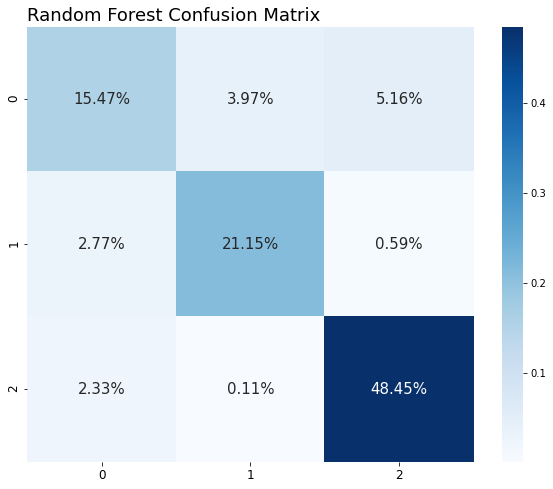

In [14]:
train_pred = cross_val_predict(rf, train_features,train_labels, cv=3)
conf_matrix_rf = confusion_matrix(train_labels, train_pred)
print(conf_matrix_rf)
plot_cm(conf_matrix_rf)

#### randomized search

In [15]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_2 = RandomForestClassifier(random_state = 42)

Random search of parameters, using 3 fold cross validation, search across 100 different combinations, and use all available cores

In [16]:
rf_random = RandomizedSearchCV(estimator = rf_2, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(train_features, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   random_state=42, verbose=2)

In [17]:
# %% best params - use these params for the next model
print(rf_random.best_params_)

{'n_estimators': 522, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': False}


#### Model with Random Search CV Params

In [18]:
rf_rs = RandomForestClassifier(n_estimators = 522,
                               min_samples_split = 2,
                               min_samples_leaf = 2,
                               max_features = 'sqrt',
                               max_depth = 110,
                               bootstrap = False)

In [19]:
rf_rs.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=False, max_depth=110, max_features='sqrt',
                       min_samples_leaf=2, n_estimators=522)

In [20]:
print(rf_rs.score(train_features, train_labels))
y_pred = rf_rs.predict(test_features)
print(accuracy_score(test_labels, y_pred))
print(classification_report(test_labels, y_pred))

1.0
0.863237139272271
                precision    recall  f1-score   support

     CANDIDATE       0.77      0.67      0.72       601
     CONFIRMED       0.86      0.87      0.87       600
FALSE POSITIVE       0.90      0.96      0.93      1190

      accuracy                           0.86      2391
     macro avg       0.85      0.83      0.84      2391
  weighted avg       0.86      0.86      0.86      2391



[[1135  274  356]
 [ 204 1516   38]
 [ 175    7 3468]]


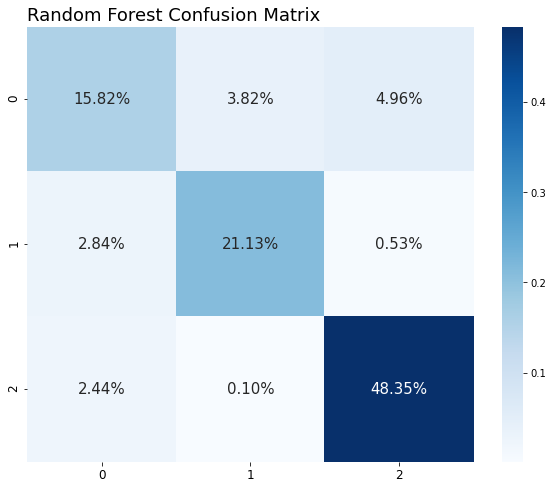

In [21]:
# confusion matrix & accuracy
rs_pred = cross_val_predict(rf_rs, train_features,train_labels, cv=3)
conf_matrix_rf = confusion_matrix(train_labels, rs_pred)
print(conf_matrix_rf)
plot_cm(conf_matrix_rf)

In [22]:
print("Accuracy score: ", accuracy_score(test_labels, rs_pred))
print("Recall score: ", recall_score(test_labels, rs_pred, average=None))
print("Precision score: ", precision_score(test_labels, rs_pred, average=None))

ValueError: Found input variables with inconsistent numbers of samples: [2391, 7173]

#### AdaBoost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5)

ada_clf.fit(train_features, train_labels)
ada_pred = ada_clf.predict(test_features)

In [ ]:
print(classification_report(test_labels, ada_pred))

#### K-Nearest Neighbor Classifier

In [24]:
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.preprocessing import StandardScaler

# standarizer = StandardScaler()
# X_std = standarizer(train_features)

knn = KNeighborsClassifier(n_neighbors=5, n_jobs = 6).fit(train_features, train_labels)
knn_preds = knn.predict(test_labels)

ValueError: could not convert string to float: 'CANDIDATE'

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors

n_neighbors = 15

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = train_features
y = train_labels

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ['darkorange', 'c', 'darkblue']

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=iris.target_names[y],
                    palette=cmap_bold, alpha=1.0, edgecolor="black")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))
    plt.xlabel(iris.feature_names[0])
    plt.ylabel(iris.feature_names[1])

plt.show()

TypeError: '(slice(None, None, None), 0)' is an invalid key